In [ ]:
# %matplotlib notebook 

In [1]:
import os
import torch
import numpy
import math
from tqdm import tqdm
import wandb

import pickle

from data.rna_object import RNA
from data.dataloader import get_train_test_dataloaders, RNATorsionalAnglesDataset, collate_fn

from torch.utils.data import DataLoader

from models.transformer import TorsionalAnglesTransformerDecoder

pdbs_path="/home2/sriram.devata/rna_project/rna_structure/data/raw_files/all_torrna_pdbs/"
processed_dir = "/ssd_scratch/users/sriram.devata/rna_structure/dataset/"
perfect_pdb_files_train_val_test_path="/home2/sriram.devata/rna_project/cdhit/torrna_train_val_test.pkl"

with open(perfect_pdb_files_train_val_test_path, "rb") as fp:
	training_pdbs, validation_pdbs, testing_pdbs = pickle.load(fp)
testing_files = list()
for each_testing_pdb in testing_pdbs:
	testing_files.append(f"{pdbs_path}/{each_testing_pdb}.pdb")

pdbs_to_predict = 1000
list_of_pdbs_to_predict = testing_files[:pdbs_to_predict]
predict_dataset = RNATorsionalAnglesDataset(list_of_pdbs_to_predict, processed_dir=processed_dir, type_dataset="test")
predict_dataloader = DataLoader(predict_dataset, collate_fn=collate_fn, batch_size=32)

Found precomputed test dataset


In [2]:
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_loader, val_loader, test_loader = get_train_test_dataloaders()

Found precomputed train dataset
Making RNATorsionalAnglesDataset...


100%|██████████| 42/42 [00:02<00:00, 17.82it/s]


Found precomputed test dataset


In [4]:
model = TorsionalAnglesTransformerDecoder()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.load_state_dict(torch.load("/home2/sriram.devata/rna_project/rna_transformer/checkpoints/torrna_most_recent_model_rna_transformer_0.0002_640_256_4_3_0.2_5.pkl", map_location=device))
model.eval()

TorsionalAnglesTransformerDecoder(
  (transformer_decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=640, out_features=640, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=640, out_features=640, bias=True)
        )
        (linear1): Linear(in_features=640, out_features=2048, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=2048, out_features=640, bias=True)
        (norm1): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
        (norm3): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
        (dropout3): Dropout(p=0.2, in

In [5]:
all_dihedral_angle_names = ["alpha ($\\alpha$)" ,"beta ($\\beta$)" ,"gamma ($\\gamma$)" ,"delta ($\\delta$)" ,"chi ($\\chi$)" ,"epsilon ($\\epsilon$)" ,"zeta ($\\zeta$)" ,"eta ($\\eta$)" ,"theta ($\\theta$)"]

def convert_to_rad_and_back_to_degree(cur_res_spot_rna_pred_angles):

	final_degree_angles = list()
	for each_angle in cur_res_spot_rna_pred_angles:
		torsion_angle = torch.tensor([each_angle * math.pi / 180])
		final_degree_angle = torch.arctan2(torch.sin(torsion_angle),torch.cos(torsion_angle)).item() * 180 / math.pi
		final_degree_angles.append(final_degree_angle)

	return final_degree_angles

def make_rad_angle_tensor_to_deg_angle_list(rad_angle_tensor):

	constructed_angles = list()
	for each_angle_idx in range(len(all_dihedral_angle_names)):
		cos_angle = rad_angle_tensor[2*each_angle_idx]
		sin_angle = rad_angle_tensor[2*each_angle_idx+1]
		rad_angle = torch.arctan2(sin_angle,cos_angle)
		deg_angle = rad_angle.item() * 180 / math.pi
		constructed_angles.append(deg_angle)

	return constructed_angles

def calculate_mae(predicted, groundtruth, prediction_method="Unknown"):

	all_angle_errors = list()
	for each_angle_idx in range(len(all_dihedral_angle_names)):
		all_angle_errors.append(list())

	for each_rna_idx in range(len(predicted)):
		for each_residue_idx in range(len(predicted[each_rna_idx])):

			predicted_angles = predicted[each_rna_idx][each_residue_idx]
			gt_angles = groundtruth[each_rna_idx][each_residue_idx]

			for each_angle_idx in range(len(all_dihedral_angle_names)):
				difference = abs(predicted_angles[each_angle_idx] - gt_angles[each_angle_idx])
				difference = min(difference, 360-difference)
				if math.isnan(difference):
					continue
				all_angle_errors[each_angle_idx].append(difference)

	return_maes = list()

	print(f"\n----------\nMAEs for all dihedral angles predicted by {prediction_method}")
	for each_angle_idx in range(len(all_dihedral_angle_names)):
		mae = sum(all_angle_errors[each_angle_idx])/len(all_angle_errors[each_angle_idx])
		return_maes.append(mae)
		print(f"{all_dihedral_angle_names[each_angle_idx]}: {mae:.3f}")

	return return_maes

In [6]:
all_predicted_angles = list()
all_gt_angles = list()
for each_batch in tqdm(test_loader):
		rna_fm_embeddings, torsional_angles, initial_embeddings, padding_mask = each_batch
		rna_fm_embeddings = rna_fm_embeddings.to(device)
		torsional_angles = torsional_angles.to(device)
		initial_embeddings = initial_embeddings.to(device)
		padding_mask = padding_mask.to(device)

		output = model(rna_fm_embeddings, padding_mask, initial_embeddings).detach().cpu()
		torsional_angles = torsional_angles.detach().cpu()

		for each_rna_idx in range(len(torsional_angles)):
			each_rna_predicted_angles = list()
			each_rna_gt_angles = list()
			for each_residue_idx in range(len(torsional_angles[each_rna_idx])):

				if padding_mask[each_rna_idx][each_residue_idx]:
					continue	# True if this residue is padded

				predicted_angles = make_rad_angle_tensor_to_deg_angle_list(output[each_rna_idx][each_residue_idx])
				gt_angles = make_rad_angle_tensor_to_deg_angle_list(torsional_angles[each_rna_idx][each_residue_idx])
				each_rna_predicted_angles.append(predicted_angles)
				each_rna_gt_angles.append(gt_angles)

			all_predicted_angles.append(each_rna_predicted_angles)
			all_gt_angles.append(each_rna_gt_angles)

100%|██████████| 6/6 [00:02<00:00,  2.25it/s]


In [7]:
all_spotrna_predicted_angles = list()
all_spotrna_gt_angles = list()

spot_rna_pred_location = "/home2/sriram.devata/rna_project/SPOT-RNA-1D/outputs/"
for each_pdb_idx in tqdm(range(len(list_of_pdbs_to_predict))):

	pdb_file_name = list_of_pdbs_to_predict[each_pdb_idx]
	rna_object = RNA(pdb_file_name, calc_rna_fm_embeddings=True, load_dssr_dihedrals=True, load_coords=False)
	gt_angles = rna_object.dssr_torsion_angles[1:]
	# print(pdb_file_name, len(rna_object.dssr_full_seq))

	pdb_code = pdb_file_name.split('/')[-1].replace(".pdb", "")
	spot_rna_pred_file = f"{spot_rna_pred_location}/{pdb_code}.txt"

	with open(spot_rna_pred_file, "r") as f:
		spot_rna_pred_lines = f.readlines()

	each_rna_predicted_angles = list()
	each_rna_gt_angles = list()
	# print(pdb_code, gt_angles.shape)
	for each_residue_idx in range(len(gt_angles)):
		spot_rna_pred_line = spot_rna_pred_lines[each_residue_idx+2]	# first two lines are column headers and an empty line
		cur_res_spot_rna_pred_angles = [float(x) for x in spot_rna_pred_line.strip().split()[2:]]	# first two columns are number and basename

		# cur_res_spot_rna_pred_angles = convert_to_rad_and_back_to_degree(cur_res_spot_rna_pred_angles)
        
                        # correcting the order of the angles, SPOT-RNA-1D has a different ordering of angles
		index_correction = [0, 1, 2, 3, 6, 4, 5, 7, 8]
		cur_res_spot_rna_pred_angles = [cur_res_spot_rna_pred_angles[x] for x in index_correction]

		cur_res_gt_angles = make_rad_angle_tensor_to_deg_angle_list(gt_angles[each_residue_idx])

		each_rna_predicted_angles.append(cur_res_spot_rna_pred_angles)
		each_rna_gt_angles.append(cur_res_gt_angles)

		# print("Pred:", cur_res_spot_rna_pred_angles)
		# print("GT  :", cur_res_gt_angles)
# 	print(f"SPOT ernapred: {len(each_rna_predicted_angles)}, ernagt: {len(each_rna_gt_angles)}")
	all_spotrna_predicted_angles.append(each_rna_predicted_angles)
	all_spotrna_gt_angles.append(each_rna_gt_angles)

100%|██████████| 172/172 [00:09<00:00, 17.47it/s]


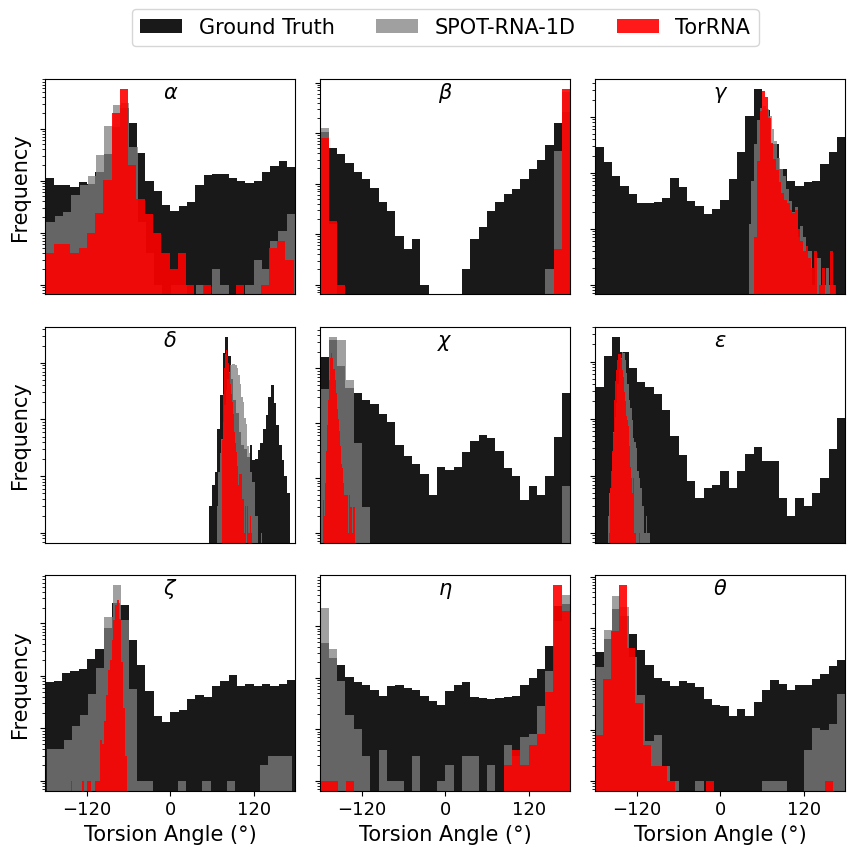

In [10]:
all_dihedral_angle_names = ["$\\alpha$" ,"$\\beta$" ,"$\\gamma$" ,"$\\delta$" ,"$\\chi$" ,"$\\epsilon$" ,"$\\zeta$" ,"$\\eta$" ,"$\\theta$"]

fig, axs = plt.subplots(3,3, figsize=(10, 8))
plt.rcParams.update({'font.size': 15})
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=7)

# fig.suptitle("Histogram of ground truth and predicted (pseudo)torsion angles")

for each_row_idx in range(3):
    for each_col_idx in range(3):
        axs[each_row_idx][each_col_idx].hist([x[each_row_idx*3+each_col_idx] for y in all_gt_angles for x in y], bins=30, alpha=0.9, label="Ground Truth", color="black")
        axs[each_row_idx][each_col_idx].hist([x[each_row_idx*3+each_col_idx] for y in all_spotrna_predicted_angles for x in y], bins=30, alpha=0.75, label="SPOT-RNA-1D", color="grey")
        axs[each_row_idx][each_col_idx].hist([x[each_row_idx*3+each_col_idx] for y in all_predicted_angles for x in y], bins=30, alpha=0.9, label="TorRNA", color="red")

        axs[each_row_idx][each_col_idx].set_xlim([-180, 180])
        axs[each_row_idx][each_col_idx].set_xticks([])
        axs[each_row_idx][each_col_idx].set_yscale('log')
        
        if each_row_idx == 2:
            axs[each_row_idx][each_col_idx].set_xlabel('Torsion Angle (°)')
            axs[each_row_idx][each_col_idx].set_xticks([-120, 0, 120])
        if each_col_idx == 0:
            axs[each_row_idx][each_col_idx].set_ylabel('Frequency')
        
        axs[each_row_idx][each_col_idx].set_title(all_dihedral_angle_names[each_row_idx*3+each_col_idx], size="medium", y=1.0, pad=-14)
        
        axs[each_row_idx][each_col_idx].yaxis.set_ticklabels([])
        

# Get the handles and labels from all the histograms
all_handles = list()
all_labels = list()
handles_spot, labels_spot = axs[0][0].get_legend_handles_labels()
handles_torrna, labels_torrna = axs[0][1].get_legend_handles_labels()
for each_label_idx , each_label in enumerate(labels_spot):
    if each_label not in all_labels:
        all_labels.append(each_label)
        all_handles.append(handles_spot[each_label_idx])
for each_label_idx , each_label in enumerate(labels_torrna):
    if each_label not in all_labels:
        all_labels.append(each_label)
        all_handles.append(handles_torrna[each_label_idx])
        

plt.subplots_adjust(left=0.1,
                    bottom=0.01, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.15)


fig.legend(all_handles, all_labels, ncols=len(all_labels), loc='upper center', bbox_to_anchor=(0.5, 1.0))

plt.savefig('images/histograms_ground_spot_tor.svg', dpi=300, bbox_inches = 'tight')
plt.show()

In [11]:
all_dihedral_angle_names = ["$\\alpha$" ,"$\\beta$" ,"$\\gamma$" ,"$\\delta$" ,"$\\chi$" ,"$\\epsilon$" ,"$\\zeta$" ,"$\\eta$" ,"$\\theta$"]

fig, axs = plt.subplots(9,3, figsize=(10, 15))

fig.suptitle("Histogram of ground truth and predicted (pseudo)torsion angles")

for dihedral_idx in range(9):
    axs[dihedral_idx][0].hist([x[dihedral_idx] for y in all_spotrna_gt_angles for x in y], bins=30, alpha=0.75, label="Ground Truth", color="black")
    axs[dihedral_idx][0].hist([x[dihedral_idx] for y in all_spotrna_predicted_angles for x in y], bins=30, alpha=0.75, label="SPOT-RNA-1D Predictions", color="yellow")
    
    axs[dihedral_idx][1].hist([x[dihedral_idx] for y in all_gt_angles for x in y], bins=30, alpha=0.75, label="Ground Truth", color="black")
    axs[dihedral_idx][1].hist([x[dihedral_idx] for y in all_predicted_angles for x in y], bins=30, alpha=0.75, label="TorRNA Predictions", color="red")

    
    axs[dihedral_idx][2].hist([x[dihedral_idx] for y in all_predicted_angles for x in y], bins=30, alpha=0.75, label="TorRNA Predictions", color="red")
    axs[dihedral_idx][2].hist([x[dihedral_idx] for y in all_spotrna_predicted_angles for x in y], bins=30, alpha=0.75, label="SPOT-RNA-1D Predictions", color="yellow")

    
    axs[dihedral_idx][0].set_xlim([-180, 180])
    axs[dihedral_idx][1].set_xlim([-180, 180])
    axs[dihedral_idx][2].set_xlim([-180, 180])
    
    axs[dihedral_idx][0].set_yscale('log')
    axs[dihedral_idx][1].set_yscale('log')
    axs[dihedral_idx][2].set_yscale('log')

# Get the handles and labels from all the histograms
all_handles = list()
all_labels = list()
handles_spot, labels_spot = axs[0][0].get_legend_handles_labels()
handles_torrna, labels_torrna = axs[0][1].get_legend_handles_labels()
for each_label_idx , each_label in enumerate(labels_spot):
    if each_label not in all_labels:
        all_labels.append(each_label)
        all_handles.append(handles_spot[each_label_idx])
for each_label_idx , each_label in enumerate(labels_torrna):
    if each_label not in all_labels:
        all_labels.append(each_label)
        all_handles.append(handles_torrna[each_label_idx])
        
    
for ax, row_label in zip(axs[:,0], all_dihedral_angle_names):
    ax.set_ylabel(row_label, rotation=0, size='medium')
fig.legend(all_handles, all_labels, loc='upper right', bbox_to_anchor=(1, 0.95))

plt.savefig('images/histograms_ground_spot_tor.svg', dpi=300)
plt.show()

KeyboardInterrupt: 

In [ ]:
for dihedral_idx in range(9):
    gt_angles = [x[dihedral_idx] for y in all_gt_angles for x in y]
    pred_angles = [x[dihedral_idx] for y in all_predicted_angles for x in y]
    periodic_pred_angles = list()
    for idx in range(len(gt_angles)):
        diff = abs(pred_angles[idx]-gt_angles[idx])
        if diff < 360 - diff:
            periodic_pred_angles.append(pred_angles[idx])
        else:
            periodic_pred_angles.append(360 - pred_angles[idx])
    data = {"gt":gt_angles, "pred":periodic_pred_angles}
    g = sns.jointplot(data=data, x="gt", y="pred", color="black", s=0.5)
    g.plot_joint(sns.kdeplot, color="black", zorder=0, levels=6)
#     g = sns.jointplot(data=data, x="gt", y="pred", kind="reg", scatter_kws={'s': 1})
    g.ax_marg_x.set_xlim(-180, 180)
    g.ax_marg_y.set_ylim(-180, 180)
    
    plt.title(all_dihedral_angle_names[dihedral_idx], y=1.2)
    plt.show()


In [ ]:
import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy.stats._continuous_distns import _distn_names
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))
        
        except Exception:
            pass

    
    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data
dihedral_idx = 0
data = [x[dihedral_idx] for y in all_gt_angles for x in y if not math.isnan(x[dihedral_idx])]

# Plot for comparison
fig, ax = plt.subplots(figsize=(12,8))

plt.hist(data, bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_distibutions = best_fit_distribution(data, 200, ax)
best_dist = best_distibutions[0]

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Dihedral Angles and all fitted distributions')
ax.set_xlabel(u'Angle (°)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist[0], best_dist[1])

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
plt.hist(data, bins=50, density=True, alpha=0.5, label='Data')

param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)

ax.set_title(u'Dihedral Angles and best fitted distributions \n' + dist_str)
ax.set_xlabel(u'Angle (°)')
ax.set_ylabel('Frequency')

In [ ]:
dihedral_idx = 0
data = [x[dihedral_idx] for y in all_gt_angles for x in y if not math.isnan(x[dihedral_idx])]

fig, ax = plt.subplots(1, 1)

import scipy
from scipy.stats import norm
import numpy as np

h,e = np.histogram(data, bins=180, density=True)
resamples = np.random.choice((e[:-1] + e[1:])/2, size=10000, p=h/h.sum())

plt.title("Native Distribution of alpha vs Random Baseline Predictor's Distribution")
plt.hist(resamples, bins=30, label="Random Baseline")
plt.hist(data, bins=30, label="Native Distribution")
ax.set_xlim([-180, 180])
ax.set_yscale('log')
plt.legend()
plt.show()